# Multimodal Product Classification


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.utils import ImageDownloader
from src.vision_embeddings_tf import get_embeddings_df
from src.nlp_models import HuggingFaceEmbeddings
from src.utils import preprocess_data, train_test_split_and_feature_extraction
import os

from src.classifiers_classic_ml import train_and_evaluate_model as train_classic

from src.classifiers_mlp import MultimodalDataset
from sklearn.preprocessing import LabelEncoder
from src.classifiers_mlp import train_mlp

## 1. Getting the data


- Download the [images](https://drive.google.com/file/d/14s2aDNTEWse86cWyLhvVIKmob6EbQrm_/view?usp=sharing)
- Place the images in the `data/images` directory.

Optionally, you can use the following Python snippet to programmatically download the images and generate the `processed_products_with_images.csv` file. This is an alternative to the manual steps above.


```py
# Load the data:
CSV_PATH = "data/raw/processed_products.csv"
df = pd.read_csv(CSV_PATH)

# Download the images and add the image paths to the dataframe:
DIR = "data/images/"
SHAPE = (224, 224)
OVERWRITE = False
OUTPUT_CSV = "data/processed_products_with_images.csv"

# Instantiate the ImageDownloader class
image_downloader = ImageDownloader(image_dir=DIR, image_size=SHAPE, overwrite=OVERWRITE)

# Download images and get the updated DataFrame
updated_df = image_downloader.download_images(df)

# Save the updated DataFrame
updated_df.to_csv(CSV_PATH, index=False)
```


## 2. EDA


- Read the data and display the first few rows.


In [ ]:
df = pd.read_csv("data/processed_products_with_images.csv")
df.head()

sku                                             name  \
0   43900                Duracell - AAA Batteries (4-Pack)   
1   48530  Duracell - AA 1.5V CopperTop Batteries (4-Pack)   
2  127687                 Duracell - AA Batteries (8-Pack)   
3  150115            Energizer - MAX Batteries AA (4-Pack)   
4  185230                  Duracell - C Batteries (4-Pack)   

                                         description  \
0  Compatible with select electronic devices; AAA...   
1  Long-lasting energy; DURALOCK Power Preserve t...   
2  Compatible with select electronic devices; AA ...   
3  4-pack AA alkaline batteries; battery tester i...   
4  Compatible with select electronic devices; C s...   

                                               image      type  price  \
0  http://img.bbystatic.com/BestBuy_US/images/pro...  HardGood   5.49   
1  http://img.bbystatic.com/BestBuy_US/images/pro...  HardGood   5.49   
2  http://img.bbystatic.com/BestBuy_US/images/pro...  HardGood   7.49   
3  http://img.bbystatic.com/BestBuy_US/images/pro...  HardGood   4.99   
4  http://img.bbystatic.com/BestBuy_US/images/pro...  HardGood   8.99   

   shipping manufacturer            class_id       sub_class1_id  num_classes  \
0      5.49     Duracell  pcmcat312300050015  pcmcat248700050021            2   
1      5.49     Duracell  pcmcat312300050015  pcmcat248700050021            2   
2      5.49     Duracell  pcmcat312300050015  pcmcat248700050021            2   
3      5.49    Energizer  pcmcat312300050015  pcmcat248700050021            2   
4      5.49     Duracell  pcmcat312300050015  pcmcat248700050021            2   

               image_path  
0   data/images/43900.jpg  
1   data/images/48530.jpg  
2  data/images/127687.jpg  
3  data/images/150115.jpg  
4  data/images/185230.jpg

- Display some images from the dataset.


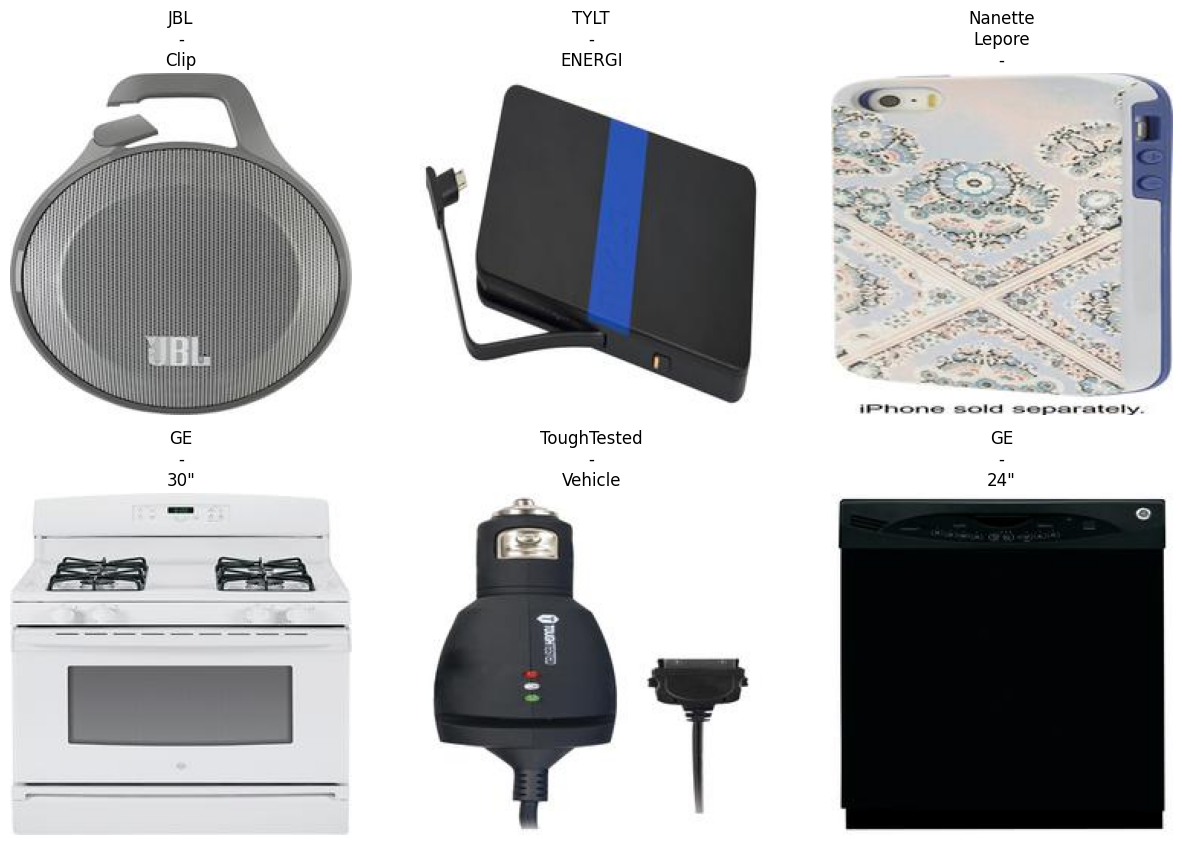

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(2):
    for j in range(3):
        # Get a random index
        idx = df.sample().index[0]
        # Read the image
        img = mpimg.imread(df.loc[idx, "image_path"])
        # Display the image
        ax[i, j].imshow(img)
        # Set the title
        ax[i, j].set_title("\n".join(df.loc[idx, "name"].split()[:3]))
        ax[i, j].axis("off")


## 3. Embedding Generation


### 3.1 Image Embeddings


We will use a pre-trained model to generate image embeddings. The model will take an image as input and output a vector of fixed size that represents the image. We will use the `get_embeddings_df` function to extract embeddings from images using a backbone model using `Tensorflow` and `Transformers`.

The function will create a file `embeddings_{model_name}.csv` containing the image name and the embeddings for each image in the dataset in the directory `embeddings`. The embeddings are represented as n columns, where n is the size of the embedding vector.


In [ ]:
batch_size = 32
path = "data/images"
dataset = ""
backbone = "convnextv2_tiny"
out_dir = "Embeddings"

get_embeddings_df(
    batch_size=batch_size,
    path=path,
    dataset_name=dataset,
    backbone=backbone,
    directory=out_dir,
)

### 3.2. Text Embeddings


For text embeddings, we will use a pre-trained model to generate embeddings for the product descriptions. The model will take a text input and output a vector of fixed size that represents the text. We will use the `HuggingFaceEmbeddings` class to extract embeddings from text using a pre-trained transformer model from the Hugging Face library.


In [ ]:
device = "cuda"  # Set to 'cuda' if you have a GPU, 'cpu' otherwise and 'mps' for MacOS
model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2", device=device
)

model.path = "data/processed_products_with_images.csv"
column = "description"
directory = "embeddings/"
file = "text_embeddings_minilm.csv"

model.get_embedding_df(column, directory, file)

### 3.3 Merge Embeddings


Once you have the embeddings, you need to merge them into a single dataset. You can use the `preprocess_data` function to merge the embeddings and preprocess the dataset for training.

The function will create a dataframe with the embeddings from both the text and image data. The dataframe will contain the text and image IDs, the product category, as well as the metadata for the product, and `n` + `m` new extra columns with the embeddings, where `n` is the size of the text embeddings and `m` is the size of the image embeddings. The new embedding columns will be named `text_0`, `text_1`, ..., `text_n`, `image_0`, `image_1`, ..., `image_m`.


In [ ]:
PATH = "embeddings/"
text_path = "text_embeddings_minilm.csv"
images_path = "Embeddings_convnextv2_tiny.csv"

# Read unimodal data
text = pd.read_csv(os.path.join(PATH, text_path))

images = pd.read_csv(os.path.join(PATH, images_path))

# Merge and preprocess the datasets
df = preprocess_data(text, images, "image_path", "ImageName")

df.to_csv(os.path.join(PATH, "embeddings_minilm.csv"), index=False)

## 4. Machine Learning Models Training


We'll be using 2 approaches to train the model:

1. A classical machine learning model using the embeddings generated from the text and image data.
2. A deep learning model using the embeddings generated from the text and image data to train a neural network.

In order to do a fair comparison between the two approaches, we will use the same train/test split for both models. We will use 70% of the data for training and 30% for testing.


### 4.1 Dataset Preparation


The first step is to prepare the dataset for training. We will use the `train_test_split` function to split function from the `sklearn` library to split the dataset into training and testing sets.


In [ ]:
# Read the data:
PATH = "embeddings/"
df = pd.read_csv(os.path.join(PATH, "embeddings_minilm.csv"))

# Split the data into train and test sets and extract the features
train_df, test_df, text_columns, image_columns, label_columns = (
    train_test_split_and_feature_extraction(df)
)

### 4.2 Classical ML model Training


After generating the embeddings, we will train a machine learning model to predict the product category based on the embeddings. We will use the `train_and_evaluate_model` (`train_classic` in this code) function to train `RandomForest` and `LogisticRegression` models using the embeddings.


In [ ]:
# Labels
y_train = train_df[label_columns].values
y_test = test_df[label_columns].values

#### 4.2.1 Train and Evaluate Text Model


####################  Random Forest  ####################


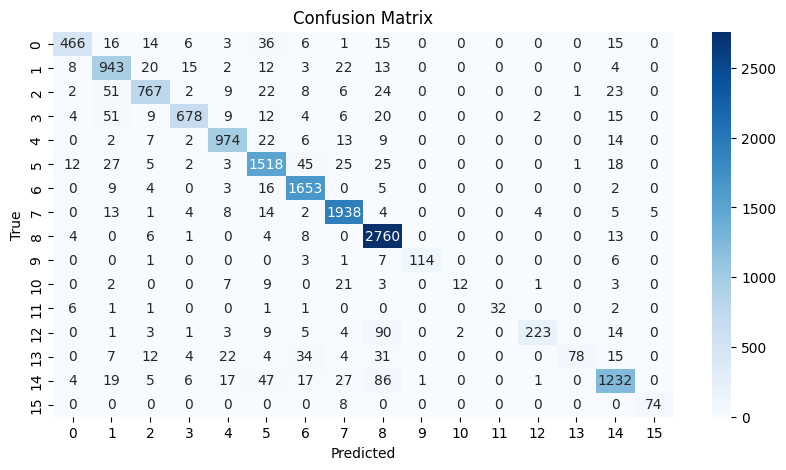

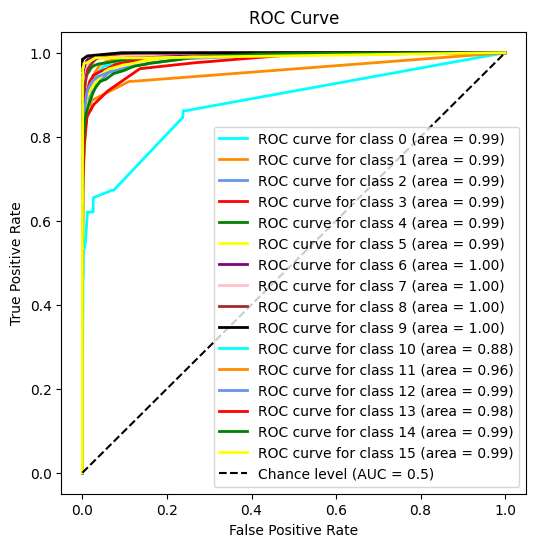

                    precision    recall  f1-score   support

      abcat0100000       0.92      0.81      0.86       578
      abcat0200000       0.83      0.90      0.86      1042
      abcat0207000       0.90      0.84      0.87       915
      abcat0300000       0.94      0.84      0.89       810
      abcat0400000       0.92      0.93      0.92      1049
      abcat0500000       0.88      0.90      0.89      1681
      abcat0700000       0.92      0.98      0.95      1692
      abcat0800000       0.93      0.97      0.95      1998
      abcat0900000       0.89      0.99      0.94      2796
          cat09000       0.99      0.86      0.92       132
pcmcat128500050004       0.86      0.21      0.33        58
pcmcat139900050002       1.00      0.73      0.84        44
pcmcat242800050021       0.97      0.63      0.76       355
pcmcat252700050006       0.97      0.37      0.54       211
pcmcat312300050015       0.89      0.84      0.87      1462
pcmcat332000050000       0.94      0.90

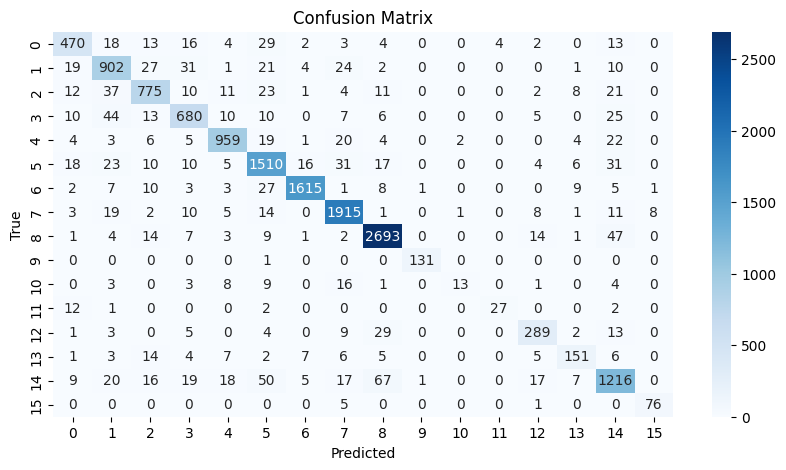

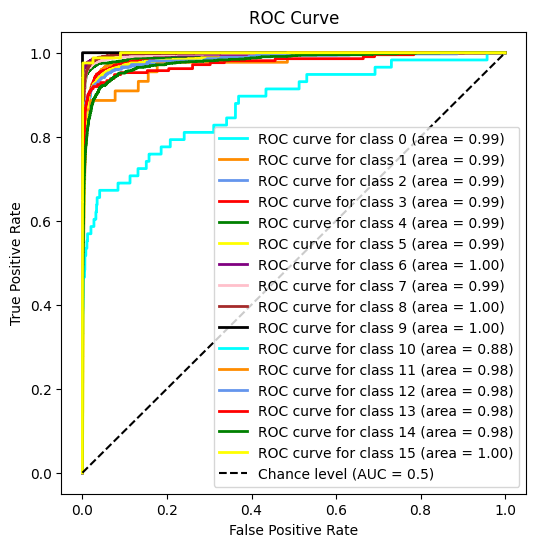

                    precision    recall  f1-score   support

      abcat0100000       0.84      0.81      0.82       578
      abcat0200000       0.83      0.87      0.85      1042
      abcat0207000       0.86      0.85      0.85       915
      abcat0300000       0.85      0.84      0.84       810
      abcat0400000       0.93      0.91      0.92      1049
      abcat0500000       0.87      0.90      0.89      1681
      abcat0700000       0.98      0.95      0.97      1692
      abcat0800000       0.93      0.96      0.94      1998
      abcat0900000       0.95      0.96      0.95      2796
          cat09000       0.98      0.99      0.99       132
pcmcat128500050004       0.81      0.22      0.35        58
pcmcat139900050002       0.87      0.61      0.72        44
pcmcat242800050021       0.83      0.81      0.82       355
pcmcat252700050006       0.79      0.72      0.75       211
pcmcat312300050015       0.85      0.83      0.84      1462
pcmcat332000050000       0.89      0.93

In [ ]:
# Combine text columns to form the feature set
X_train = train_df[text_columns].values
X_test = test_df[text_columns].values

# Train and evaluate models
trained_models = train_classic(X_train, X_test, y_train, y_test)

#### 4.2.2 Train and Evaluate Image Model


####################  Random Forest  ####################


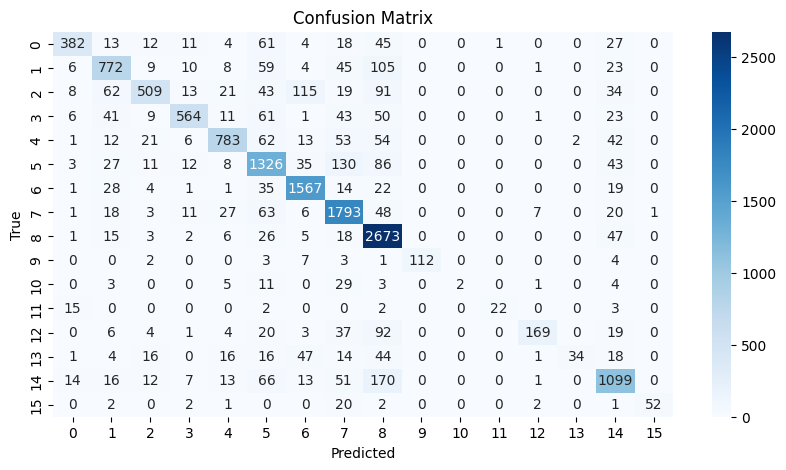

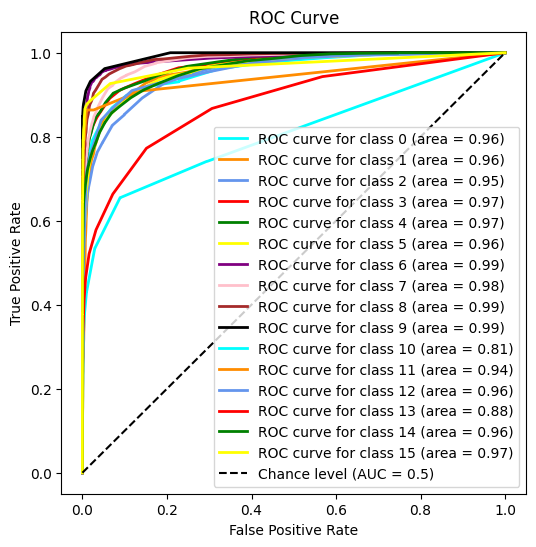

                    precision    recall  f1-score   support

      abcat0100000       0.87      0.66      0.75       578
      abcat0200000       0.76      0.74      0.75      1042
      abcat0207000       0.83      0.56      0.67       915
      abcat0300000       0.88      0.70      0.78       810
      abcat0400000       0.86      0.75      0.80      1049
      abcat0500000       0.72      0.79      0.75      1681
      abcat0700000       0.86      0.93      0.89      1692
      abcat0800000       0.78      0.90      0.84      1998
      abcat0900000       0.77      0.96      0.85      2796
          cat09000       1.00      0.85      0.92       132
pcmcat128500050004       1.00      0.03      0.07        58
pcmcat139900050002       0.96      0.50      0.66        44
pcmcat242800050021       0.92      0.48      0.63       355
pcmcat252700050006       0.94      0.16      0.28       211
pcmcat312300050015       0.77      0.75      0.76      1462
pcmcat332000050000       0.98      0.63

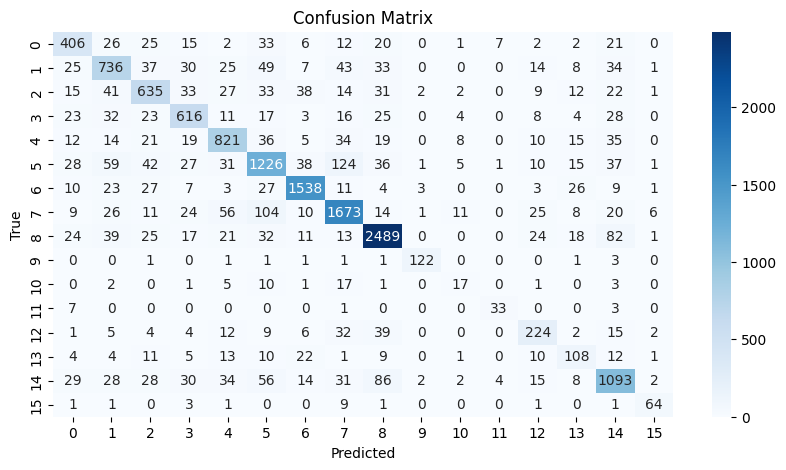

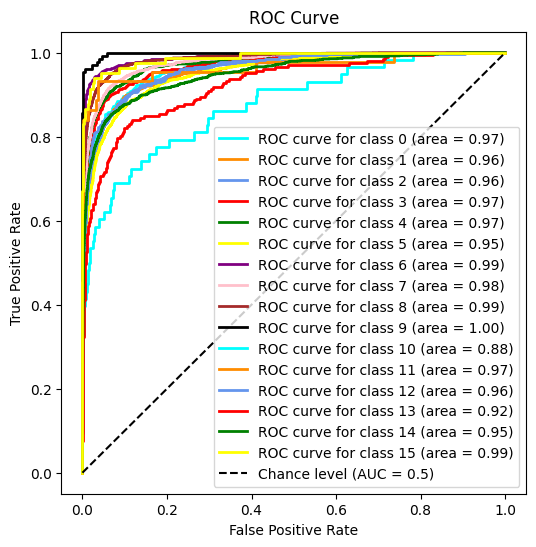

                    precision    recall  f1-score   support

      abcat0100000       0.68      0.70      0.69       578
      abcat0200000       0.71      0.71      0.71      1042
      abcat0207000       0.71      0.69      0.70       915
      abcat0300000       0.74      0.76      0.75       810
      abcat0400000       0.77      0.78      0.78      1049
      abcat0500000       0.75      0.73      0.74      1681
      abcat0700000       0.90      0.91      0.91      1692
      abcat0800000       0.82      0.84      0.83      1998
      abcat0900000       0.89      0.89      0.89      2796
          cat09000       0.93      0.92      0.93       132
pcmcat128500050004       0.33      0.29      0.31        58
pcmcat139900050002       0.73      0.75      0.74        44
pcmcat242800050021       0.63      0.63      0.63       355
pcmcat252700050006       0.48      0.51      0.49       211
pcmcat312300050015       0.77      0.75      0.76      1462
pcmcat332000050000       0.80      0.78

In [ ]:
# Combine image columns to form the feature set
X_train = train_df[image_columns].values
X_test = test_df[image_columns].values

# Train and evaluate models
trained_models = train_classic(X_train, X_test, y_train, y_test)

#### 4.2.3 Train and Evaluate Combined Model


####################  Random Forest  ####################


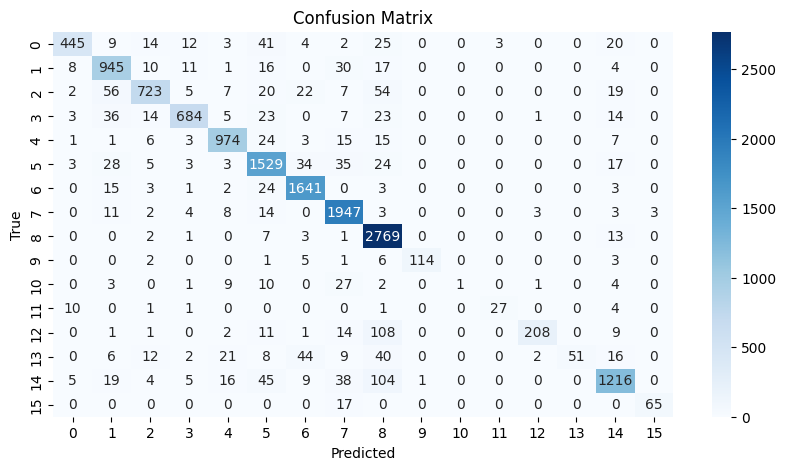

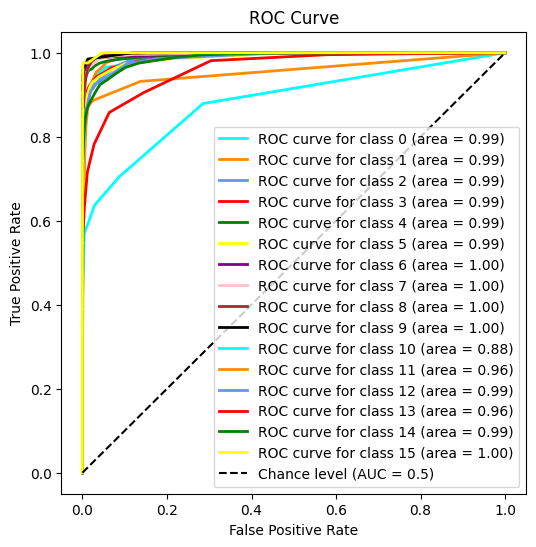

                    precision    recall  f1-score   support

      abcat0100000       0.93      0.77      0.84       578
      abcat0200000       0.84      0.91      0.87      1042
      abcat0207000       0.90      0.79      0.84       915
      abcat0300000       0.93      0.84      0.89       810
      abcat0400000       0.93      0.93      0.93      1049
      abcat0500000       0.86      0.91      0.89      1681
      abcat0700000       0.93      0.97      0.95      1692
      abcat0800000       0.91      0.97      0.94      1998
      abcat0900000       0.87      0.99      0.92      2796
          cat09000       0.99      0.86      0.92       132
pcmcat128500050004       1.00      0.02      0.03        58
pcmcat139900050002       0.90      0.61      0.73        44
pcmcat242800050021       0.97      0.59      0.73       355
pcmcat252700050006       1.00      0.24      0.39       211
pcmcat312300050015       0.90      0.83      0.86      1462
pcmcat332000050000       0.96      0.79

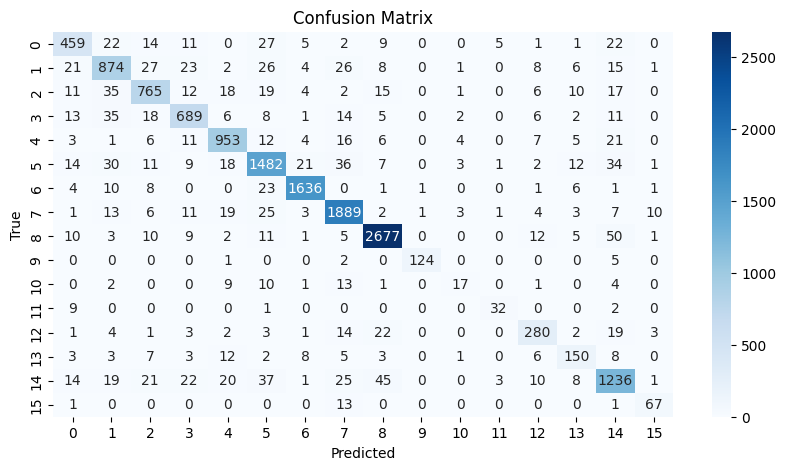

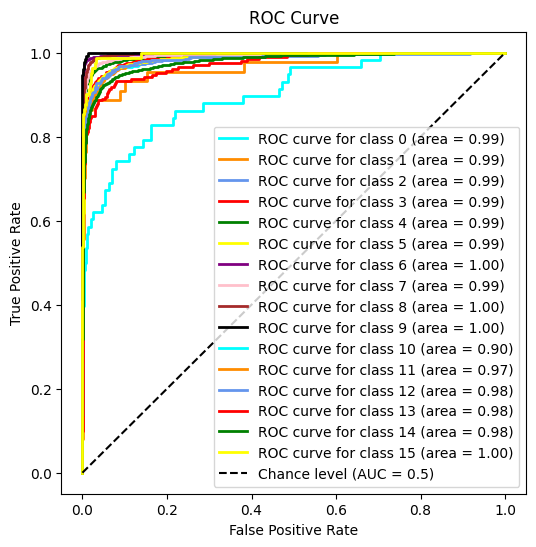

                    precision    recall  f1-score   support

      abcat0100000       0.81      0.79      0.80       578
      abcat0200000       0.83      0.84      0.84      1042
      abcat0207000       0.86      0.84      0.85       915
      abcat0300000       0.86      0.85      0.85       810
      abcat0400000       0.90      0.91      0.90      1049
      abcat0500000       0.88      0.88      0.88      1681
      abcat0700000       0.97      0.97      0.97      1692
      abcat0800000       0.92      0.95      0.93      1998
      abcat0900000       0.96      0.96      0.96      2796
          cat09000       0.98      0.94      0.96       132
pcmcat128500050004       0.53      0.29      0.38        58
pcmcat139900050002       0.76      0.73      0.74        44
pcmcat242800050021       0.81      0.79      0.80       355
pcmcat252700050006       0.71      0.71      0.71       211
pcmcat312300050015       0.85      0.85      0.85      1462
pcmcat332000050000       0.79      0.82

In [ ]:
# Combine text and image columns to form the feature set
X_train = train_df[text_columns + image_columns].values
X_test = test_df[text_columns + image_columns].values

# Train and evaluate models
trained_models = train_classic(X_train, X_test, y_train, y_test)

### 4.3 Multi-layer Perceptron


We'll use a Multi-layer Perceptron (MLP) is a simple neural network consisting of multiple layers of nodes connected by weighted edges. The input and output layers have one node per feature, and one node per target class respectively, while the intermediate layers have an arbitrary number of nodes.

Once you train each model, it will generate a classification report and a confusion matrix to evaluate the model's performance. It will also generate a folder `results` with the files `results/multimodal_results.csv`, `results/image_results.csv`, or `results/text_results.csv` containing the results of your model on the test set.


#### 4.3.1 Prepare the dataset


In [ ]:
# Initialize LabelEncoder and fit it only on the training data
label_encoder = LabelEncoder()
label_encoder.fit(train_df[label_columns])

#### 4.3.2. Train and Evaluate the image model


In [4]:
# Create the datasets and ensure the encoder is passed to both train and test sets
train_dataset = MultimodalDataset(
    train_df,
    text_cols=None,
    image_cols=image_columns,
    label_col=label_columns,
    encoder=label_encoder,
)
test_dataset = MultimodalDataset(
    test_df,
    text_cols=None,
    image_cols=image_columns,
    label_col=label_columns,
    encoder=label_encoder,
)

text_input_size = None
image_input_size = len(image_columns)
output_size = label_encoder.classes_.shape[0]

Training Image Model:
Epoch 1/50


2025-08-27 07:35:42.046366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-27 07:35:42.046931: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2025-08-27 07:35:42.046995: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-08-27 07:35:42.047705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
1/1 [==============================] - 0s 16ms/step


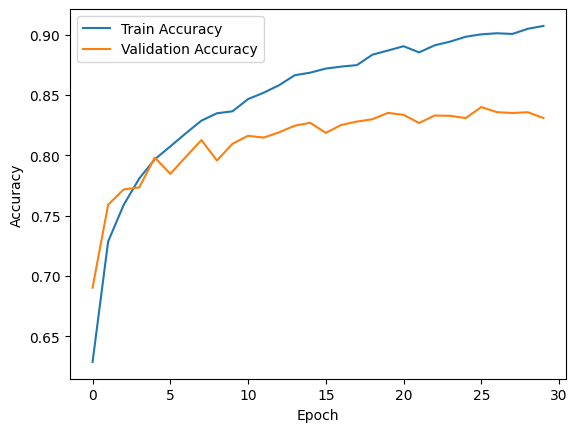

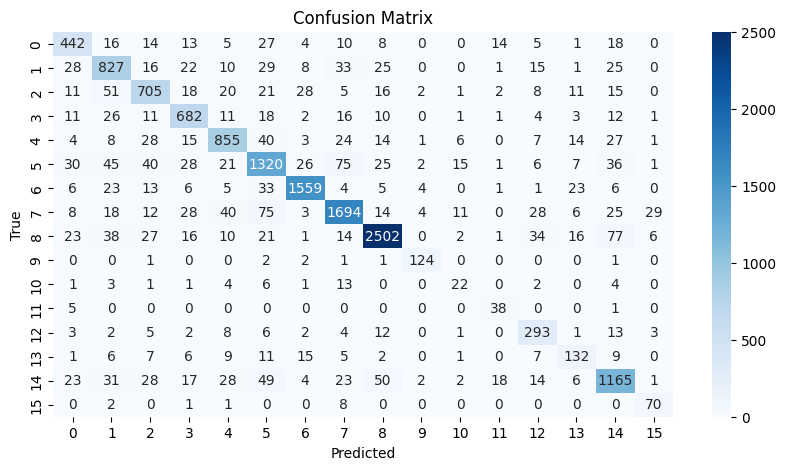

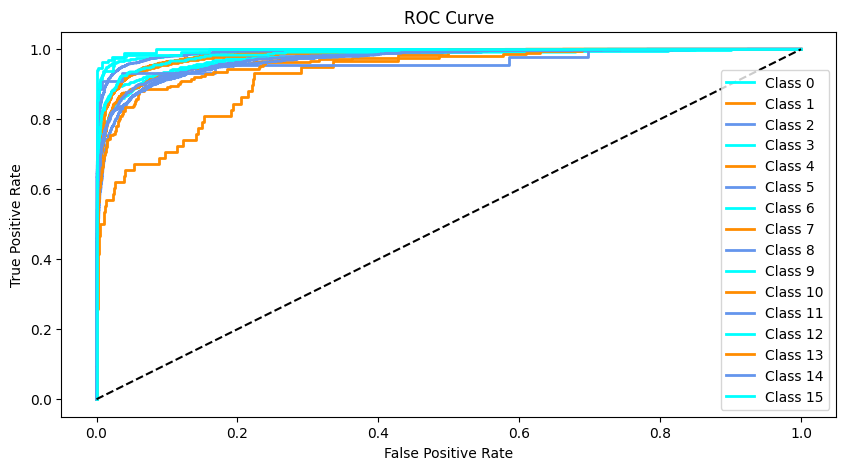

                    precision    recall  f1-score   support

      abcat0100000       0.74      0.77      0.75       577
      abcat0200000       0.75      0.80      0.77      1040
      abcat0207000       0.78      0.77      0.77       914
      abcat0300000       0.80      0.84      0.82       809
      abcat0400000       0.83      0.82      0.82      1047
      abcat0500000       0.80      0.79      0.79      1678
      abcat0700000       0.94      0.92      0.93      1689
      abcat0800000       0.88      0.85      0.86      1995
      abcat0900000       0.93      0.90      0.91      2788
          cat09000       0.89      0.94      0.92       132
pcmcat128500050004       0.35      0.38      0.37        58
pcmcat139900050002       0.49      0.86      0.63        44
pcmcat242800050021       0.69      0.83      0.75       355
pcmcat252700050006       0.60      0.63      0.61       211
pcmcat312300050015       0.81      0.80      0.80      1461
pcmcat332000050000       0.62      0.85

(<keras.engine.functional.Functional at 0x712fdbb80d90>,
 0.8353494623655914,
 0.7654132294692897,
 0.9767977795752117)

In [5]:
# Train the model
print("Training Image Model:")
train_mlp(
    train_dataset,
    test_dataset,
    text_input_size=text_input_size,
    image_input_size=image_input_size,
    output_size=output_size,
    num_epochs=50,
    report=True,
    lr=0.001,
    set_weights=True,
    adam=True,
    p=0.2,
    seed=42,
    patience=10,
)

#### 4.3.3. Train and Evaluate the text model


In [6]:
# Create the datasets and ensure the encoder is passed to both train and test sets
train_dataset = MultimodalDataset(
    train_df,
    text_cols=text_columns,
    image_cols=None,
    label_col=label_columns,
    encoder=label_encoder,
)
test_dataset = MultimodalDataset(
    test_df,
    text_cols=text_columns,
    image_cols=None,
    label_col=label_columns,
    encoder=label_encoder,
)

text_input_size = len(text_columns)
image_input_size = None
output_size = label_encoder.classes_.shape[0]

Training Text Model:
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
1/1 [==============================] - 0s 14ms/step


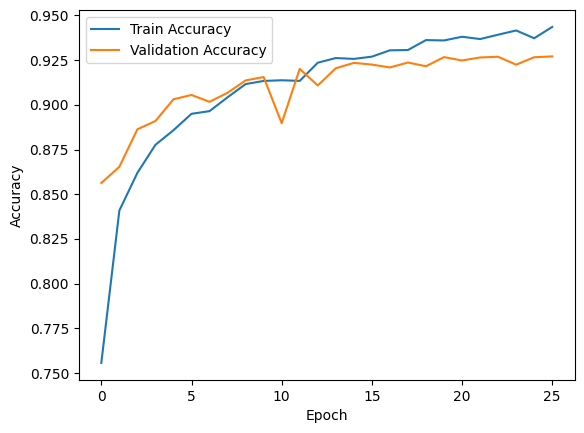

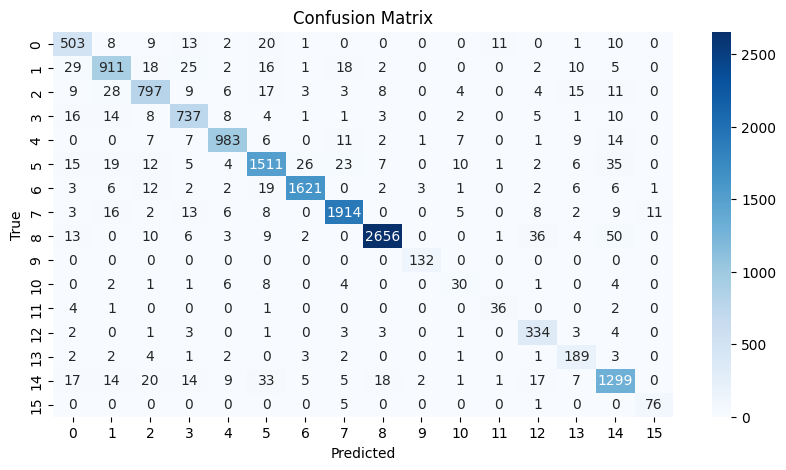

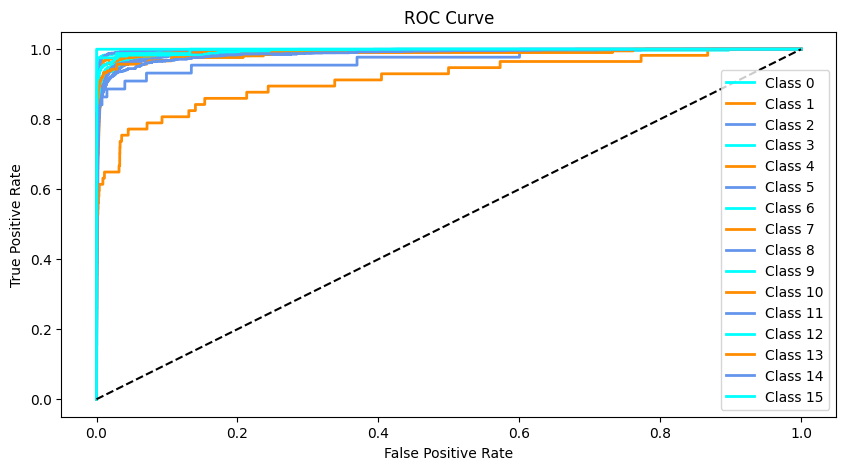

                    precision    recall  f1-score   support

      abcat0100000       0.82      0.87      0.84       578
      abcat0200000       0.89      0.88      0.88      1039
      abcat0207000       0.88      0.87      0.88       914
      abcat0300000       0.88      0.91      0.90       810
      abcat0400000       0.95      0.94      0.94      1048
      abcat0500000       0.91      0.90      0.91      1676
      abcat0700000       0.97      0.96      0.97      1686
      abcat0800000       0.96      0.96      0.96      1997
      abcat0900000       0.98      0.95      0.97      2790
          cat09000       0.96      1.00      0.98       132
pcmcat128500050004       0.48      0.53      0.50        57
pcmcat139900050002       0.72      0.82      0.77        44
pcmcat242800050021       0.81      0.94      0.87       355
pcmcat252700050006       0.75      0.90      0.82       210
pcmcat312300050015       0.89      0.89      0.89      1462
pcmcat332000050000       0.86      0.93

(<keras.engine.functional.Functional at 0x712fdb644790>,
 0.9226478494623656,
 0.8727951769439136,
 0.9871873958110775)

In [7]:
# Train the model
print("Training Text Model:")
train_mlp(
    train_dataset,
    test_dataset,
    text_input_size=text_input_size,
    image_input_size=image_input_size,
    output_size=output_size,
    num_epochs=50,
    report=True,
    lr=0.001,
    set_weights=True,
    adam=True,
    p=0.2,
    seed=42,
    patience=10,
)

#### 4.3.4. Train and Evaluate the fusion model


In [8]:
# Create the datasets and ensure the encoder is passed to both train and test sets
train_dataset = MultimodalDataset(
    train_df,
    text_cols=text_columns,
    image_cols=image_columns,
    label_col=label_columns,
    encoder=label_encoder,
)
test_dataset = MultimodalDataset(
    test_df,
    text_cols=text_columns,
    image_cols=image_columns,
    label_col=label_columns,
    encoder=label_encoder,
)

text_input_size = len(text_columns)
image_input_size = len(image_columns)
output_size = label_encoder.classes_.shape[0]

Training Early Fusion Model:
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
1/1 [==============================] - 0s 16ms/step


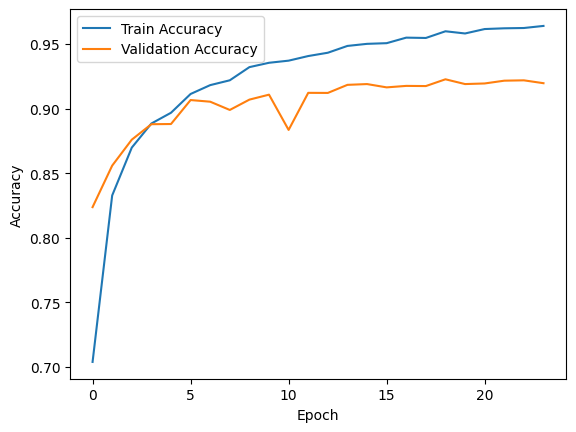

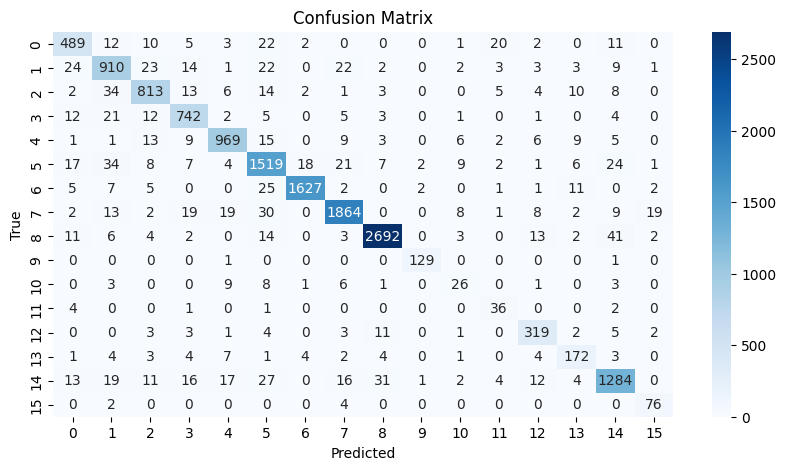

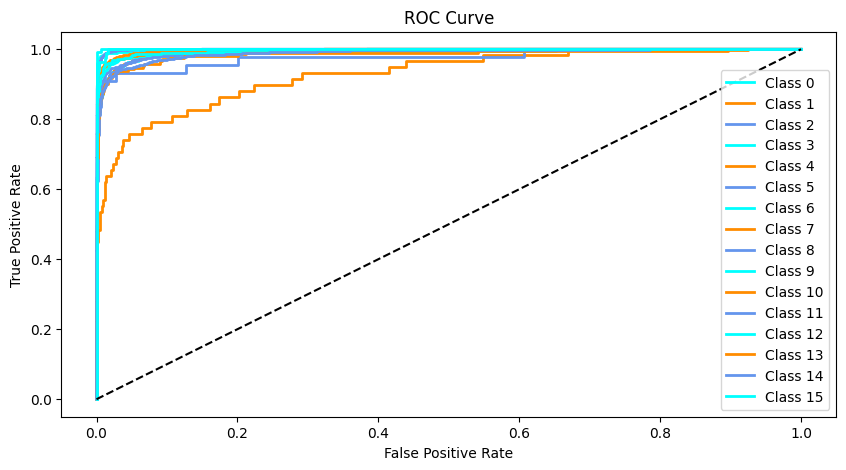

                    precision    recall  f1-score   support

      abcat0100000       0.84      0.85      0.84       577
      abcat0200000       0.85      0.88      0.86      1039
      abcat0207000       0.90      0.89      0.89       915
      abcat0300000       0.89      0.92      0.90       808
      abcat0400000       0.93      0.92      0.93      1048
      abcat0500000       0.89      0.90      0.90      1680
      abcat0700000       0.98      0.96      0.97      1688
      abcat0800000       0.95      0.93      0.94      1996
      abcat0900000       0.98      0.96      0.97      2793
          cat09000       0.96      0.98      0.97       131
pcmcat128500050004       0.43      0.45      0.44        58
pcmcat139900050002       0.49      0.82      0.61        44
pcmcat242800050021       0.85      0.90      0.88       354
pcmcat252700050006       0.78      0.82      0.80       210
pcmcat312300050015       0.91      0.88      0.90      1457
pcmcat332000050000       0.74      0.93

(<keras.engine.functional.Functional at 0x712fd7b75ca0>,
 0.9184811827956989,
 0.8520235541452087,
 0.9890127426458555)

In [9]:
# Train the model
print("Training Early Fusion Model:")
train_mlp(
    train_dataset,
    test_dataset,
    text_input_size=text_input_size,
    image_input_size=image_input_size,
    output_size=output_size,
    num_epochs=50,
    report=True,
    lr=0.001,
    set_weights=True,
    adam=True,
    p=0.2,
    seed=42,
    patience=10,
)

## 5. Model Selection
